### **Testing the anti-Darmois metric**

Test the metric by Michel (anti Darmois Metric, aDM);

**1a) Is it $0$ for scalar functions?**

**A:** Apparently so.

**1b) Is it $\geq 0$ otherwise?**

**A:** Apparently so, although it sometimes gets nonzero (e.g.); I hope it is a numerical error, to be checked.

**1c) Test on the closed form Darmois: 
        Does the metric attain a higher value for the true mixing f than for inv_darmois --- i.e.  aDM(inv_darmois)>aDM(f) typically?**

**A:** **Apparently not**. At least in 2d. Why? Investigate!

**1d) Is the metric invariant to scalar reparametrisations?**

**A:** Apparently so -- again, up to (hopefully) numeric precision.

**1e) Is it $=0$ for conformal mappings? See https://pypi.org/project/confmap/?**

**A:** **Work in progress!**

#### See experiments answering questions 1a to 1d below.

In [11]:
import jax
from jax import numpy as np
from jax import vmap
from jax import jacfwd

from jax import random
key = random.PRNGKey(42)

import numpy as onp

from metrics import aDM

Testing the anti-Darmois metric,

$$\text{mMI}(\mathbf{f}, \mathbf{s}) = \int \sum_{i = 1}^D \log || \nabla f_i(\mathbf{s}) ||_2 - \log | J_\mathbf{f}(\mathbf{s})| p(\mathbf{s}) d\mathbf{s}$$

.

We generate the sources and keep them fixed throughout our simulations.

In [12]:
# N:=Number of samples
N = 6000
# D:=Number of dimensions
D = 2

# Generate the samples
S = random.uniform(key, shape=(N, D), minval=0.0, maxval=1.0)

**1a)** Is the metric equal to zero for scalar mixings?

In [13]:
from jax.scipy import special

def f_scalar(x):
    '''
    An arbitrary scalar nonlinear transformation
    
    Input: x: a 2d random variable
    
    Output: a 2d random variable. 
    1st component = x[0]**3
    2nd component = special.erfinv(x[1]*2.0-1.0)
    '''
    return np.array([x[0]**3, special.erfinv(x[1]*2.0-1.0)])

Jf_scalar = jacfwd(f_scalar)
Jf_scalar_batched = vmap(Jf_scalar)

aDM(Jf_scalar_batched, S)

DeviceArray(0., dtype=float32)

Apparently so.

**1b)** Is the metric >0 otherwise?

Hard to check in general, let's see for the three mixing from Aapo's paper.

In [14]:
from mixing_functions import f_1, f_2, f_3

In [15]:
Jf_1, Jf_2, Jf_3 = jacfwd(f_1), jacfwd(f_2), jacfwd(f_3)
Jf_1_batched, Jf_2_batched, Jf_3_batched = vmap(Jf_1), vmap(Jf_2), vmap(Jf_3)

In [16]:
aDM(Jf_1_batched, S)

DeviceArray(0.09358136, dtype=float32)

In [17]:
aDM(Jf_2_batched, S)

DeviceArray(0.7167423, dtype=float32)

In [18]:
aDM(Jf_3_batched, S)

DeviceArray(1.0244665, dtype=float32)

Apparently so.

It also look like the more nonlinear the function, the higher the value of **aDM**.

**1c)** Test it on the closed form Darmois.

For now limited to 2d.

In [19]:
# True mixing
from mixing_functions import f_g_unl

# Darmois construction
from mixing_functions import darmois_linear_gaussian, darmois_linear_gaussian_2d

from scipy.stats import ortho_group

reps = 3*10**2

# Accumulate metric values for histogram
true_aDM_s = onp.zeros(reps)
inv_darmois_aDM_s = onp.zeros(reps)


# How many times do we "spot" the Darmois construction?
positive = 0

for i in range(reps):
    
    # Generate mixing
    A = random.multivariate_normal(key, mean=np.zeros(D*2), cov=np.eye(D*2)).reshape(2,2)
#     A = ortho_group.rvs(dim=2)
    
    f_unl, _ = f_g_unl(A)
    f_unl_batched = vmap(f_unl)
    
    X = f_unl_batched(S)
    
    # Compute the batched Jacobian
    Jf_unl = jacfwd(f_unl)
    Jf_unl_batched = vmap(Jf_unl)
    # Compute aDM true
    true_aDM = aDM(Jf_unl_batched, S)

    # Build Darmois
#     darmois_single, inv_darmois_single = darmois_linear_gaussian_2d(A)
    darmois_single, inv_darmois_single = darmois_linear_gaussian(A)
    darmois, inv_darmois = vmap(darmois_single), vmap(inv_darmois_single)

    # Sources w. Darmois construction
    Y = darmois(X)

    # Compute the batched Jacobian
    Jinv_darmois = jacfwd(inv_darmois_single)
    Jinv_darmois_batched = vmap(Jinv_darmois)
    # Compute aDM for inv Darmois
    inv_darmois_aDM = aDM(Jinv_darmois_batched, Y)
    
    true_aDM_s[i] = true_aDM
    inv_darmois_aDM_s[i] = inv_darmois_aDM
    
    if true_aDM < inv_darmois_aDM:
        positive+=1
    
    # Update random key
    key+=1
        
print(positive/reps)

0.3433333333333333


7.504423
2.5137627


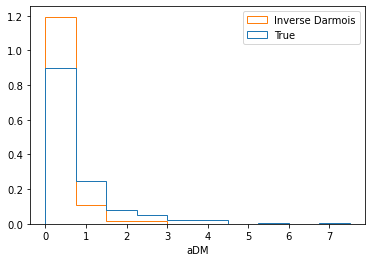

In [20]:
import matplotlib.pyplot as plt

from plotting import plot_histograms

plot_histograms([true_aDM_s, inv_darmois_aDM_s],
               ['True', 'Inverse Darmois'],
               'aDM')

print(np.max(true_aDM_s))
print(np.max(inv_darmois_aDM_s))

### **Problem: Does not appear to be the case that aDM is higher for Darmois than true function!**

In 2d and with our own peculiar mixing this happens only $\sim 30 \%$ of the cases.

Why?

- Artifact of lower dimension, disappears for $D>2$?
- Artifact of simple mixing, disappears for more nonlinear ones?

Investigate!

**1d)** Is the metric invariant to scalar reparametrisation? 

That is, for any $(p(\mathbf{s}), \mathbf{f})$ and $(p(\tilde{\mathbf{s}}), \tilde{\mathbf{f}})$, with $\tilde{\mathbf{s}}=\mathbf{h}^{-1}(\mathbf{s})$ and $\tilde{\mathbf{f}}=\mathbf{f}\circ\mathbf{h}$, where $\mathbf{h}(\mathbf{s})$ is a component-wise invertible nonlinearity $\mathbf{h}(\mathbf{s})=[h_1(s_1), ..., h_n(s_n)]$, it must hold

$$\text{aDM}(p(\mathbf{s}), \mathbf{f}) = \text{aDM}(p(\tilde{\mathbf{s}}), \tilde{\mathbf{f}}) $$

In [21]:
# N:=Number of samples
N = 6000
# D:=Number of dimensions
Dims = [2]#, 10, 20, 30, 50]

In [22]:
# True mixing
from mixing_functions import f_g_unl, f_lin


from scipy.stats import ortho_group

reps = 3*10**2

# Accumulate metric values for histograms
true_aDM_s_lin = onp.zeros((reps, len(Dims)))
true_aDM_s_unl = onp.zeros((reps, len(Dims)))

In [23]:
# How many times do we "spot" the Darmois construction?
# positive = onp.zeros(len(Dims))

for idx, Dim in enumerate(Dims):
    # Generate the samples
    S = random.uniform(key, shape=(N, Dim), minval=0.0, maxval=1.0)
    S_normal = special.erfinv(S*2.0-1.0)
    for i in range(reps):

        # Generate mixing
        A = random.multivariate_normal(key, mean=np.zeros(Dim*Dim), cov=np.eye(Dim*Dim)).reshape(Dim,Dim)
#         A = ortho_group.rvs(dim=Dim)

        # Linear mixing      
        f, _ = f_lin(A)
        f_batched = vmap(f)

        # Compute the batched Jacobian
        Jf = jacfwd(f)
        Jf_batched = vmap(Jf)
        # Compute aDM
        # NOTE THAT THIS HAS TO BE APPLIED TO S_normal
        true_aDM_lin = aDM(Jf_batched, S_normal)


        # Nonlinear mixing (uniform to normal then linearly mixed)
        f, _ = f_g_unl(A)
        f_batched = vmap(f)
    
        # Compute the batched Jacobian
        Jf = jacfwd(f)
        Jf_batched = vmap(Jf)
        # Compute aDM
        # NOTE THAT THIS HAS TO BE APPLIED TO THE UNIFORM R.V.'s S
        true_aDM_unl = aDM(Jf_batched, S)
        
        # Update random key
        key+=1

        true_aDM_s_lin[i, idx] = true_aDM_lin
        true_aDM_s_unl[i, idx] = true_aDM_unl
        
    print("Dimension =", Dim)

Dimension = 2


5.121138


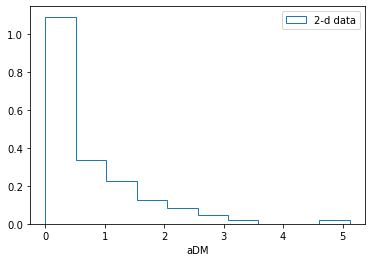

In [24]:
hist_values = [true_aDM_s_lin[:, i] for i in range(len(Dims))]
labels = [str(a)+"-d data" for a in Dims]

plot_histograms(hist_values,
               labels,
               'aDM')

print(np.max(true_aDM_s_lin))

5.121136


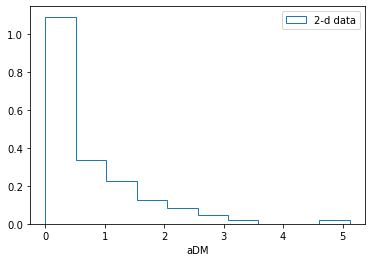

In [25]:
hist_values = [true_aDM_s_unl[:, i] for i in range(len(Dims))]
labels = [str(a)+"-d data" for a in Dims]

plot_histograms(hist_values,
               labels,
               'aDM')


print(np.max(true_aDM_s_unl))

The histograms appear to be the same.

In [26]:
np.max(np.abs(true_aDM_s_lin-true_aDM_s_unl))

DeviceArray(1.9073486e-06, dtype=float32)

Also pointwise, the values seem to differ at most by a very small value (hopefully numerical error?)

**1e)** Is the metric =0 for conformal mappings?

In [27]:
# How can I generate a random conformal mapping? See link below?
# https://pypi.org/project/confmap/

In [28]:
# Or maybe 
# https://github.com/AndrewWalker/cmtoolkit

In [29]:
# Or even simpler, I can generate a
# fully connected MLP where all of the matrices are orthogonal; but that alone 
# is insufficient, in fact beware of:

# https://arxiv.org/pdf/2011.13831.pdf

# Pierre only refers to _linear_ neural networks (no nonlinearity among the layers).

# "The Jacobian at each point is a _positive scalar_ times a rotation matrix"

# Jacobian of the composition = product of the Jacobians;
# How can I implement this with a neural network;
# Maybe does not work because with a scalar nonlinearity it is not a _positive scalar_, rather a diagonal matrix
# You _can_ however have a point-wise multiplication times a scalar.

#### How to test this?
#### A possibility is to exploit Liouville theorem
#### And check that the resulting transformation is indeed conformal

https://en.wikipedia.org/wiki/Conformal_map

> Any conformal map on a portion of Euclidean space **of dimension three or greater** can be composed from three types of transformations: a homothety, an isometry, and a special conformal transformation.

The idea here being that homothety + isometry is maybe not exhaustive of all possible conformal maps but can already represent a few.

Hopefully also in 2d.

In [30]:
def build_conformal_map(lambd, R_theta, s):
    
    def conformal_map(x):
        y = x - s
        y *= lambd
        return R_theta @ y
    
    def conformal_map_gridplot(x, y):
        x -= s[0]
        y -= s[1]
        x *= lambd 
        y *= lambd 
        return R_theta[0][0]*x + R_theta[0][1]*y, R_theta[1][0]*x + R_theta[1][1]*y
    
    return conformal_map, conformal_map_gridplot

In [31]:
lambd = 2.0

s_star = np.array([2.0, -3.5])

theta = np.radians(30)
c, s = np.cos(theta), np.sin(theta)
R_theta = np.array(((c, -s), (s, c)))

conformal_map, conformal_map_gridplot = build_conformal_map(lambd, R_theta, s_star)

In [32]:
conformal_map(np.array([0.0, 0.0]))

conformal_map_batched = vmap(conformal_map)

In [33]:
X_conf = conformal_map_batched(S)

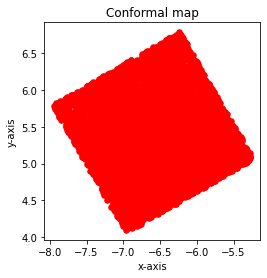

In [34]:
from plotting import scatterplot_variables

scatterplot_variables(X_conf, "Conformal map")

In [35]:
conformal_map(np.array([0.0, 0.0]))

DeviceArray([-6.964102 ,  4.0621777], dtype=float32)

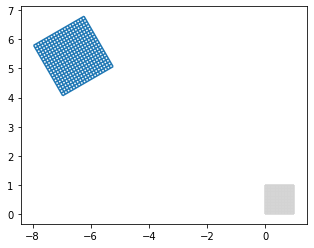

In [36]:
from plotting import show_grid_plot

# show_grid_plot(conformal_map)#, multi_argument=False)
show_grid_plot(conformal_map_gridplot, multi_argument=True)

In [37]:
Jconformal_map = jacfwd(conformal_map)

In [38]:
Jconformal_map_batched = vmap(Jconformal_map)

In [39]:
aDM(Jconformal_map_batched, S)

DeviceArray(0., dtype=float32)

#### Let's instead use complex numbers

In [129]:
def build_conformal_map(nonlinearity):
    
    def conformal_map(x):
        x-= 0.5
        z = x[0] + x[1]*1j
        y = nonlinearity(z)
        re = np.real(y)
        imag = np.imag(y)
        return np.array([re, imag])
    
    def conformal_map_gridplot(x_0, x_1):
        x_0-= 0.5
        x_1-= 0.5
        z = x_0 + x_1*1j
        y = nonlinearity(z)
        re = np.real(y)
        imag = np.imag(y)
        return re, imag
    
    return conformal_map, conformal_map_gridplot

In [130]:
a = 3 + 1j
a**2

(8+6j)

In [162]:
# nonlinearity = lambda x : x**3
# nonlinearity = lambda x : np.tanh(x)
nonlinearity = lambda x : np.log(x)
# nonlinearity = lambda x : np.exp(x)

In [163]:
conformal_map, conformal_map_gridplot = build_conformal_map(nonlinearity)

In [164]:
conformal_map(np.array([0.0, 0.0]))

conformal_map_batched = vmap(conformal_map)

In [165]:
X_conf = conformal_map_batched(S)

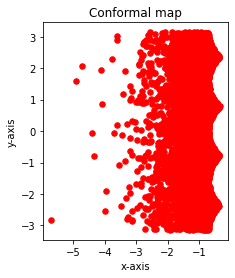

In [166]:
from plotting import scatterplot_variables

scatterplot_variables(X_conf, "Conformal map")

In [167]:
conformal_map(np.array([0.0, 0.0]))

DeviceArray([-0.34657362, -2.3561945 ], dtype=float32)

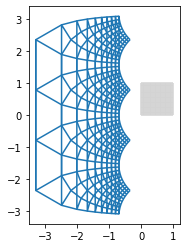

In [168]:
from plotting import show_grid_plot

# show_grid_plot(conformal_map)#, multi_argument=False)
show_grid_plot(conformal_map_gridplot, multi_argument=True)

In [169]:
Jconformal_map = jacfwd(conformal_map)

In [170]:
Jconformal_map_batched = vmap(Jconformal_map)

In [171]:
aDM(Jconformal_map_batched, S)

DeviceArray(-2.0662942e-09, dtype=float32)